### Load Full dataset and Pre,During and Post MCR + and - values

In [62]:
import pandas as pd

df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\BA_Featured_MCR.csv")
df_pre      = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_pre.csv") 
df_during   = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_BA_mcr_df_during.csv")
df_post     = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_post.csv")  


print("Shapes:", df_features.shape, df_pre.shape, df_during.shape, df_post.shape)
display(df_features.head(3))
display(df_pre.head(3))
display(df_during.head(3))
display(df_post.head(3))

Shapes: (3217, 46) (29, 3) (29, 3) (29, 3)


,overall_rating,review_date,verified_flag,travel_class,seat_comfort,staff_service,ground_service,value_for_money,recommended,food_quality,...,travel_type_missing,type_Business,type_Couple,type_Family,type_Solo,type_Unknown,food_quality_missing,wifi_missing,entertainment_missing,ground_service_missing
0,1.0,2023-11-19,2,1,1,1,1.0,1,0,2.0,...,0,False,True,False,False,False,1,1,1,0
1,3.0,2023-11-19,2,1,2,3,1.0,2,0,1.0,...,0,True,False,False,False,False,0,0,0,0
2,8.0,2023-11-16,1,3,3,3,4.0,3,1,4.0,...,0,False,True,False,False,False,0,1,1,0


,variable,MCR-,MCR+
0,verified_flag,0.012539,0.016681
1,travel_class,0.030393,0.038999
2,seat_comfort,1.258806,1.360692


,variable,MCR-,MCR+
0,verified_flag,0.010384,0.024887
1,travel_class,0.013638,0.029727
2,seat_comfort,0.449197,0.786237


,variable,MCR-,MCR+
0,verified_flag,0.000000,0.905139
1,travel_class,0.000000,1.797859
2,seat_comfort,0.068523,7.883940


In [63]:
import pandas as pd

# Load your dataset
df_features = pd.read_csv(BASE / f_features)

# Convert review_date to datetime
df_features["review_date"] = pd.to_datetime(df_features["review_date"])

# Function to tag covid period
def assign_covid_period(date):
    if date < pd.Timestamp("2020-01-01"):
        return "pre"
    elif pd.Timestamp("2020-01-01") <= date <= pd.Timestamp("2021-12-31"):
        return "during"
    else:
        return "post"

# Apply covid period labeling
df_features["covid_period"] = df_features["review_date"].apply(assign_covid_period)

# Split into subsets
df_pre_data = df_features[df_features["covid_period"] == "pre"]
df_during_data = df_features[df_features["covid_period"] == "during"]
df_post_data = df_features[df_features["covid_period"] == "post"]

# Quick sanity check
print("All data:", df_features.shape)
print("Pre-COVID:", df_pre_data.shape)
print("During COVID:", df_during_data.shape)
print("Post-COVID:", df_post_data.shape)

All data: (3217, 47)
Pre-COVID: (2559, 47)
During COVID: (191, 47)
Post-COVID: (467, 47)


## Dynamic Feature Categorization via Model Class Reliance (MCR)
 - Classifies features into Core, Volatile, or No-use
 - Uses thresholds: median of MCR+ and 25th percentile of MCR-
 - Core     = High MCR+ & High MCR- (stable importance)
 - Volatile = High MCR+ & Low MCR-  (unstable utility)
 - No-use   = Otherwise (limited contribution)
 - Adds period label (e.g., Pre-COVID) for temporal comparison


In [64]:
def classify_features_dynamic(mcr_df, period):
    plus_median = mcr_df["MCR+"].median()
    minus_q25   = mcr_df["MCR-"].quantile(0.25)

    cats = []
    for _, row in mcr_df.iterrows():
        f, mcr_minus, mcr_plus = row["variable"], row["MCR-"], row["MCR+"]
        if mcr_plus >= plus_median and mcr_minus >= minus_q25:
            cats.append((f, "Core"))
        elif mcr_plus >= plus_median and mcr_minus < minus_q25:
            cats.append((f, "Volatile"))
        else:
            cats.append((f, "No-use"))
    return pd.DataFrame(cats, columns=["Feature","Category"]).assign(Period=period)

# Apply for Pre
pre_classes = classify_features_dynamic(df_pre, "Pre-COVID")
display(pre_classes.sort_values("Category"))

,Feature,Category,Period
14,lounge_sentiment,Core,Pre-COVID
16,cleanliness_sentiment,Core,Pre-COVID
21,topic_business_experience,Core,Pre-COVID
22,topic_meals_food,Core,Pre-COVID
13,refunds_sentiment,Core,Pre-COVID
11,staff_sentiment,Core,Pre-COVID
10,seat_sentiment,Core,Pre-COVID
17,airport_service_sentiment,Core,Pre-COVID
9,food_sentiment,Core,Pre-COVID
6,entertainment_score,Core,Pre-COVID


## Feature Classification with Model Class Reliance (MCR)

- Categorizes features as Core, Volatile, or No-use
- Thresholds: median of MCR+ (importance), cutoff of MCR- (stability)
- Core = high MCR+ and MCR- above cutoff (stable importance)
- Volatile = high MCR+ and MCR- near zero (unstable utility)
- No-use = low MCR+ regardless of MCR-
- Returns labeled DataFrame with feature, category, MCR-, MCR+, and period

In [65]:
def classify_features_mcr(mcr_df, period, minus_cutoff=0.05, plus_cutoff=None):
    """
    Classify features into Core, Volatile, or No-use using MCR+ and MCR-.
    
    Theory:
    - Core      = consistently important (MCR+ high, MCR- not close to 0)
    - Volatile  = conditionally important (MCR+ high, MCR- ~ 0)
    - No-use    = weak overall (MCR+ low)
    """
    
    # Decide thresholds
    if plus_cutoff is None:
        plus_cutoff = mcr_df["MCR+"].median()   # data-driven cutoff for "important"
    
    cats = []
    for _, row in mcr_df.iterrows():
        f, mcr_minus, mcr_plus = row["variable"], row["MCR-"], row["MCR+"]
        
        if mcr_plus < plus_cutoff:
            category = "No-use"
        else:
            if mcr_minus < minus_cutoff:   # very low stability
                category = "Volatile"
            else:
                category = "Core"
        
        cats.append((f, category, mcr_minus, mcr_plus))
    
    return pd.DataFrame(cats, columns=["Feature","Category","MCR-","MCR+"]).assign(Period=period)


# Example: Apply for Pre-COVID
pre_classes = classify_features_mcr(df_pre, "Pre-COVID")
display(pre_classes.sort_values("Category"))

,Feature,Category,MCR-,MCR+,Period
14,lounge_sentiment,Core,0.194302,0.232595,Pre-COVID
16,cleanliness_sentiment,Core,0.103491,0.123029,Pre-COVID
21,topic_business_experience,Core,0.108044,0.157086,Pre-COVID
22,topic_meals_food,Core,0.072497,0.130174,Pre-COVID
13,refunds_sentiment,Core,0.194406,0.220030,Pre-COVID
11,staff_sentiment,Core,0.644448,0.715276,Pre-COVID
10,seat_sentiment,Core,0.350492,0.406106,Pre-COVID
17,airport_service_sentiment,Core,0.226743,0.265871,Pre-COVID
9,food_sentiment,Core,0.673639,0.749901,Pre-COVID
6,entertainment_score,Core,0.135560,0.162264,Pre-COVID


In [66]:
during_classes = classify_features_mcr(df_during, "During-COVID")
display(during_classes.sort_values("Category"))

,Feature,Category,MCR-,MCR+,Period
14,lounge_sentiment,Core,1.437512e-01,2.718132e-01,During-COVID
16,cleanliness_sentiment,Core,1.262673e-01,2.374974e-01,During-COVID
20,topic_refunds_lounge,Core,1.314658e-01,2.501247e-01,During-COVID
21,topic_business_experience,Core,1.791384e-01,3.905819e-01,During-COVID
13,refunds_sentiment,Core,2.874463e-01,4.811578e-01,During-COVID
11,staff_sentiment,Core,9.377254e-01,1.618342e+00,During-COVID
10,seat_sentiment,Core,1.059538e-01,2.023220e-01,During-COVID
17,airport_service_sentiment,Core,1.640868e-01,3.284092e-01,During-COVID
9,food_sentiment,Core,6.079063e-01,1.047059e+00,During-COVID
5,food_quality,Core,1.820421e-01,3.407003e-01,During-COVID


In [67]:
post_classes = classify_features_mcr(df_post, "Post-COVID")
display(post_classes.sort_values("Category"))

,Feature,Category,MCR-,MCR+,Period
2,seat_comfort,Core,6.852271e-02,7.883940,Post-COVID
4,ground_service,Core,9.164882e-02,9.606638,Post-COVID
20,topic_refunds_lounge,Core,7.152034e-02,8.962741,Post-COVID
9,food_sentiment,Core,7.023555e-02,7.960385,Post-COVID
10,seat_sentiment,Core,6.295507e-02,5.344540,Post-COVID
0,verified_flag,No-use,0.000000e+00,0.905139,Post-COVID
26,wifi_missing,No-use,2.379253e-09,1.319058,Post-COVID
25,food_quality_missing,No-use,0.000000e+00,2.273448,Post-COVID
24,travel_type_missing,No-use,0.000000e+00,0.034261,Post-COVID
23,topic_baggage,No-use,8.137045e-03,2.821627,Post-COVID


# Feature Interaction Analysis

## 1. Load Data
- Read feature and MCR datasets
- Assign COVID period (pre, during, post)

## 2. Feature Classification
- Classify features: Core, Volatile, No-use
- Keep only Core + Volatile

## 3. SHAP Interactions
- Train LightGBM per period
- Compute SHAP interaction values
- Rank top feature pairs and plot heatmap

## Output
- Use Core + Volatile features
- Target = overall rating
- Show top 10 interactions


In [68]:
!pip install lightgbm

In [69]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
import pandas as pd
import numpy as np
from pathlib import Path
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\BA_Featured_MCR.csv")
df_pre      = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_pre.csv")  
df_during   = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_BA_mcr_df_during.csv")   
df_post     = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_post.csv")    

print("Shapes:", df_features.shape, df_pre.shape, df_during.shape, df_post.shape)

# ================================
# 2. ASSIGN COVID PERIOD
# ================================
df_features["review_date"] = pd.to_datetime(df_features["review_date"])

def assign_covid_period(date):
    if date < pd.Timestamp("2020-01-01"):
        return "pre"
    elif pd.Timestamp("2020-01-01") <= date <= pd.Timestamp("2021-12-31"):
        return "during"
    else:
        return "post"

df_features["covid_period"] = df_features["review_date"].apply(assign_covid_period)

df_pre_data    = df_features[df_features["covid_period"] == "pre"]
df_during_data = df_features[df_features["covid_period"] == "during"]
df_post_data   = df_features[df_features["covid_period"] == "post"]

print("Pre-COVID:", df_pre_data.shape)
print("During-COVID:", df_during_data.shape)
print("Post-COVID:", df_post_data.shape)

# ================================
# 3. FEATURE CLASSIFICATION FUNCTION
# ================================
def classify_features_dynamic(mcr_df, period):
    plus_median = mcr_df["MCR+"].median()
    minus_q25   = mcr_df["MCR-"].quantile(0.25)

    cats = []
    for _, row in mcr_df.iterrows():
        f, mcr_minus, mcr_plus = row["variable"], row["MCR-"], row["MCR+"]
        if mcr_plus >= plus_median and mcr_minus >= minus_q25:
            cats.append((f, "Core"))
        elif mcr_plus >= plus_median and mcr_minus < minus_q25:
            cats.append((f, "Volatile"))
        else:
            cats.append((f, "No-use"))
    return pd.DataFrame(cats, columns=["Feature","Category"]).assign(Period=period)

# Apply to each period
pre_classes    = classify_features_dynamic(df_pre, "Pre-COVID")
during_classes = classify_features_dynamic(df_during, "During-COVID")
post_classes   = classify_features_dynamic(df_post, "Post-COVID")

# Select usable features
pre_feats    = pre_classes.query("Category != 'No-use'")["Feature"].tolist()
during_feats = during_classes.query("Category != 'No-use'")["Feature"].tolist()
post_feats   = post_classes.query("Category != 'No-use'")["Feature"].tolist()

print("Pre-COVID usable features:", len(pre_feats))
print("During-COVID usable features:", len(during_feats))
print("Post-COVID usable features:", len(post_feats))

Shapes: (3217, 46) (29, 3) (29, 3) (29, 3)
Pre-COVID: (2559, 47)
During-COVID: (191, 47)
Post-COVID: (467, 47)
Pre-COVID usable features: 15
During-COVID usable features: 15
Post-COVID usable features: 15


In [71]:
# ================================
# 4. SHAP INTERACTION FUNCTION
# ================================
def get_interactions(X, y, period_name, top_n=10):
    # Sample down to avoid memory blowup
    sample_idx = np.random.choice(X.index, size=min(3000, len(X)), replace=False)
    X_sample = X.loc[sample_idx].fillna(0)
    y_sample = y.loc[sample_idx]

    # Train LightGBM (handles interactions natively)
    model =  lgb.LGBMRegressor(n_estimators=500, max_depth=6, random_state=42, verbose=-1)
    model.fit(X_sample, y_sample)

    # SHAP interaction values
    explainer = shap.TreeExplainer(model)
    shap_inter = explainer.shap_interaction_values(X_sample)

    feat_names = X_sample.columns
    n_feat = len(feat_names)

    # Aggregate mean absolute interactions
    pairs = []
    for i in range(n_feat):
        for j in range(i+1, n_feat):
            score = np.mean(np.abs(shap_inter[:, i, j]))
            pairs.append((feat_names[i], feat_names[j], score))

    df_interactions = (
        pd.DataFrame(pairs, columns=["Feature1","Feature2","MeanAbsSHAP"])
        .sort_values("MeanAbsSHAP", ascending=False)
    )

    print(f"\n=== Top {top_n} Interactions ({period_name}) ===")
    display(df_interactions.head(top_n))

    # Heatmap of top features only
    top_feats = df_interactions.head(top_n)[["Feature1","Feature2"]].stack().unique()
    top_idx = [list(feat_names).index(f) for f in top_feats]

    mat = np.zeros((len(top_feats), len(top_feats)))
    for i, fi in enumerate(top_idx):
        for j, fj in enumerate(top_idx):
            if i < j:
                mat[i,j] = mat[j,i] = np.mean(np.abs(shap_inter[:, fi, fj]))

    plt.figure(figsize=(10,8))
    sns.heatmap(mat, xticklabels=top_feats, yticklabels=top_feats, cmap="Blues")
    plt.title(f"Top {top_n} Feature Interactions ({period_name})")
    plt.show()

    return df_interactions

### Automated Interaction Testing
- Split data into train/test sets
- Train baseline LightGBM model (no interaction features) → get RMSE and R²
- Single interaction testing:
  - For each top interaction pair
  - Add only that one interaction term (Feature1 × Feature2)
  - Train and evaluate model
  - Store results in `df_single`
- Return baseline metrics, single interaction results

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def test_interactions(X, y, top_interactions, period_name):
    # Split base data
    X_train, X_test, y_train, y_test = train_test_split(
        X.fillna(0), y, test_size=0.2, random_state=42
    )

    # Baseline model
    base_model = lgb.LGBMRegressor(
        n_estimators=500, max_depth=6, random_state=42, verbose=-1
    )
    base_model.fit(X_train, y_train)
    pred_base = base_model.predict(X_test)
    rmse_base = sqrt(mean_squared_error(y_test, pred_base))
    r2_base = r2_score(y_test, pred_base)

    print(f"\n=== {period_name} Baseline ===")
    print(f"Baseline -> RMSE: {rmse_base:.4f}, R²: {r2_base:.4f}")

    # --- SINGLE interactions ---
    single_results = []
    for f1, f2, _ in top_interactions.itertuples(index=False):
        X_int = X.copy()
        colname = f"{f1}_{f2}"
        X_int[colname] = X_int[f1] * X_int[f2]

        Xi_train, Xi_test, yi_train, yi_test = train_test_split(
            X_int.fillna(0), y, test_size=0.2, random_state=42
        )
        model = lgb.LGBMRegressor(n_estimators=500, max_depth=6, random_state=42)
        model.fit(Xi_train, yi_train)
        pred = model.predict(Xi_test)

        rmse = sqrt(mean_squared_error(yi_test, pred))
        r2 = r2_score(yi_test, pred)
        single_results.append((f"{f1} × {f2}", rmse, r2))

    df_single = (
        pd.DataFrame(single_results, columns=["Interaction", "RMSE", "R2"])
        .sort_values("RMSE")
        .reset_index(drop=True)
    )

    print(f"\n=== {period_name} Single Interactions ===")
    display(df_single)

    return rmse_base, r2_base, df_single

# Pre-COVID interaction analysis:
- Table of top 10 feature interactions   
- Heatmap of the top features  


=== Top 10 Interactions (pre-COVID) ===


,Feature1,Feature2,MeanAbsSHAP
42,food_quality,staff_sentiment,0.103044
0,seat_comfort,staff_service,0.102450
2,seat_comfort,food_quality,0.089049
4,seat_comfort,food_sentiment,0.088691
40,food_quality,food_sentiment,0.076448
17,staff_service,food_sentiment,0.065339
6,seat_comfort,staff_sentiment,0.054244
1,seat_comfort,ground_service,0.047849
19,staff_service,staff_sentiment,0.047005
61,food_sentiment,staff_sentiment,0.042292


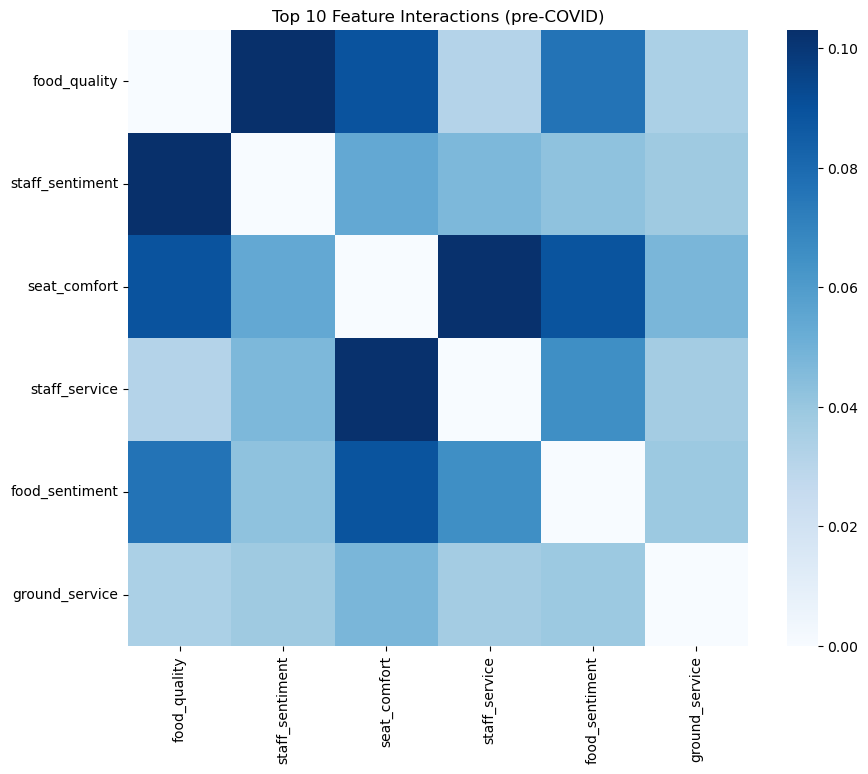

In [73]:
X_pre = df_pre_data[pre_feats]
y_pre= df_pre_data["overall_rating"]
top_pre = get_interactions(X_pre, y_pre, "pre-COVID", top_n=10)

- Train LightGBM → get SHAP interaction values → rank top-N pairs.  
- Add each pair (f1×f2) → test with LightGBM for RMSE/R² change vs baseline.  
- Fit OLS baseline → add interactions one by one → run ANOVA (F, p).  
- Report SHAP scores, predictive lift, and statistical significance.  

In [79]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

def test_interactions_linear(X, y, top_interactions, period_name):
    results = []
    
    df = X.copy()
    df["y"] = y
    formula_base = "y ~ " + " + ".join(X.columns)
    base_model = smf.ols(formula_base, data=df).fit()

    print(f"\n=== {period_name} Baseline OLS ===")
    print(base_model.summary().tables[0])  # model fit summary

    # --- Test each interaction separately ---
    for f1, f2, _ in top_interactions.itertuples(index=False):
        colname = f"{f1}_x_{f2}"
        df[colname] = df[f1] * df[f2]

        # Model with interaction term
        formula_int = formula_base + f" + {colname}"
        int_model = smf.ols(formula_int, data=df).fit()

        # Compare baseline vs interaction model
        anova_res = sm.stats.anova_lm(base_model, int_model)
        f_val = anova_res["F"].iloc[1]
        p_val = anova_res["Pr(>F)"].iloc[1]

        results.append((f"{f1} × {f2}", f_val, p_val, int_model.rsquared))

    df_results = pd.DataFrame(results, columns=["Interaction", "F", "p_value", "R2"])

    print(f"\n=== {period_name} Interaction Tests (OLS) ===")
    display(df_results.sort_values("p_value"))

    return df_results

In [81]:
X_pre = df_pre_data[pre_feats]
y_pre = df_pre_data["overall_rating"]

results_pre = test_interactions_linear(
    X_pre, y_pre, top_pre.head(5), "Pre-COVID"
)


=== Pre-COVID Baseline OLS ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     628.2
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:23:12   Log-Likelihood:                -4548.0
No. Observations:                2559   AIC:                             9128.
Df Residuals:                    2543   BIC:                             9222.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         

=== Pre-COVID Interaction Tests (OLS) ===


,Interaction,F,p_value,R2
1,seat_comfort × staff_service,63.244459,2.721528e-15,0.792632
4,food_quality × food_sentiment,47.679633,6.316829e-12,0.791386
3,seat_comfort × food_sentiment,45.693076,1.709269e-11,0.791226
2,seat_comfort × food_quality,41.674594,1.286759e-10,0.790901
0,food_quality × staff_sentiment,38.619301,6.000263e-10,0.790654


# During-COVID interaction analysis:


=== Top 10 Interactions (During-COVID) ===


,Feature1,Feature2,MeanAbsSHAP
42,food_quality,staff_sentiment,0.120879
38,ground_service,topic_business_experience,0.114934
31,ground_service,staff_sentiment,0.077118
4,seat_comfort,food_sentiment,0.072371
83,staff_sentiment,topic_business_experience,0.069454
37,ground_service,topic_refunds_lounge,0.049501
43,food_quality,refunds_sentiment,0.047688
1,seat_comfort,ground_service,0.043168
70,seat_sentiment,refunds_sentiment,0.041723
19,staff_service,staff_sentiment,0.041584


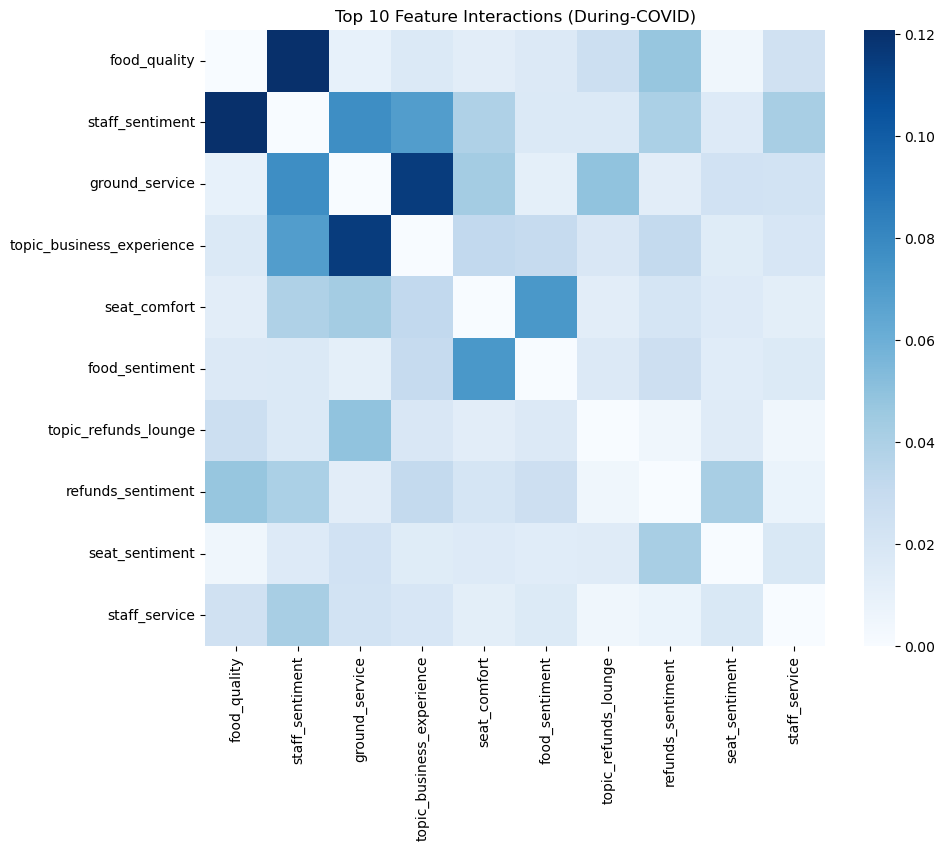

In [82]:
X_during = df_during_data[during_feats]
y_during = df_during_data["overall_rating"]

top_during = get_interactions(X_during, y_during, "During-COVID", top_n=10)

In [84]:
# During-COVID
X_during = df_during_data[during_feats]
y_during = df_during_data["overall_rating"]

results_during = test_interactions_linear(
    X_during, y_during, top_during.head(5), "During-COVID"
)


=== During-COVID Baseline OLS ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     59.04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           3.12e-60
Time:                        02:25:54   Log-Likelihood:                -330.38
No. Observations:                 191   AIC:                             692.8
Df Residuals:                     175   BIC:                             744.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         

=== During-COVID Interaction Tests (OLS) ===


,Interaction,F,p_value,R2
1,ground_service × topic_business_experience,7.359018,0.007343,0.841705
0,food_quality × staff_sentiment,6.580558,0.011153,0.841022
4,staff_sentiment × topic_business_experience,4.941944,0.027500,0.839567
3,seat_comfort × food_sentiment,3.279048,0.071895,0.838062
2,ground_service × staff_sentiment,2.048669,0.154133,0.836930


# Post-COVID interaction analysis: 


=== Top 10 Interactions (Post-COVID) ===


,Feature1,Feature2,MeanAbsSHAP
28,ground_service,food_sentiment,0.122288
1,seat_comfort,ground_service,0.096917
36,ground_service,topic_refunds_lounge,0.073047
5,seat_comfort,staff_sentiment,0.056527
27,ground_service,food_quality,0.055680
71,staff_sentiment,lounge_sentiment,0.054335
47,food_quality,topic_refunds_lounge,0.044032
41,food_quality,staff_sentiment,0.042335
3,seat_comfort,food_sentiment,0.040130
50,food_sentiment,seat_sentiment,0.036543


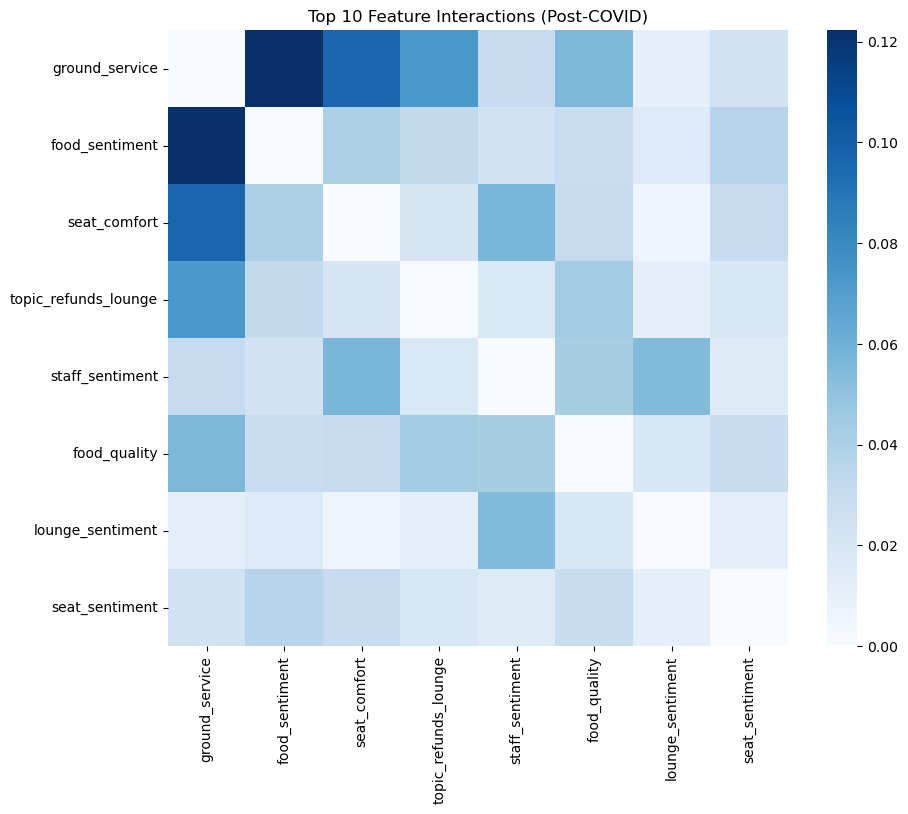

In [26]:
X_post = df_post_data[post_feats]
y_post = df_post_data["overall_rating"]

top_post = get_interactions(X_post, y_post, "Post-COVID", top_n=10)

In [85]:
X_post = df_post_data[post_feats]
y_post = df_post_data["overall_rating"]

results_post = test_interactions_linear(
    X_post, y_post, top_post.head(5), "Post-COVID"
)


=== Post-COVID Baseline OLS ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     111.6
Date:                Mon, 01 Sep 2025   Prob (F-statistic):          3.92e-141
Time:                        02:27:15   Log-Likelihood:                -828.19
No. Observations:                 467   AIC:                             1688.
Df Residuals:                     451   BIC:                             1755.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         

=== Post-COVID Interaction Tests (OLS) ===


,Interaction,F,p_value,R2
4,ground_service × food_quality,37.845122,1.693724e-09,0.804237
1,seat_comfort × ground_service,30.784042,4.930580e-08,0.801362
0,ground_service × food_sentiment,28.141642,1.772484e-07,0.800264
3,seat_comfort × staff_sentiment,28.007715,1.891770e-07,0.800208
2,ground_service × topic_refunds_lounge,0.823112,3.647573e-01,0.788161


# ICE + PDP + 2PDP Plots of Interactions

In [95]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

def plot_interactions(X, y, features, model, period_name):
    model.fit(X, y)

    # --- PDP + ICE combined (1D) ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Feature 1
    PartialDependenceDisplay.from_estimator(
        model, X, [features[0]], ax=ax[0], kind="both", subsample=50, random_state=42
    )
    ax[0].set_title(f"{period_name}: PDP + ICE {features[0]}")

    # Feature 2
    PartialDependenceDisplay.from_estimator(
        model, X, [features[1]], ax=ax[1], kind="both", subsample=50, random_state=42
    )
    ax[1].set_title(f"{period_name}: PDP + ICE {features[1]}")

    plt.tight_layout()
    plt.show()

    # --- 2D PDP for interaction ---
    fig, ax = plt.subplots(figsize=(6, 5))
    PartialDependenceDisplay.from_estimator(
        model, X, [features], ax=ax, kind="average", grid_resolution=30
    )
    ax.set_title(f"{period_name}: 2D PDP {features[0]} × {features[1]}")
    plt.tight_layout()
    plt.show()

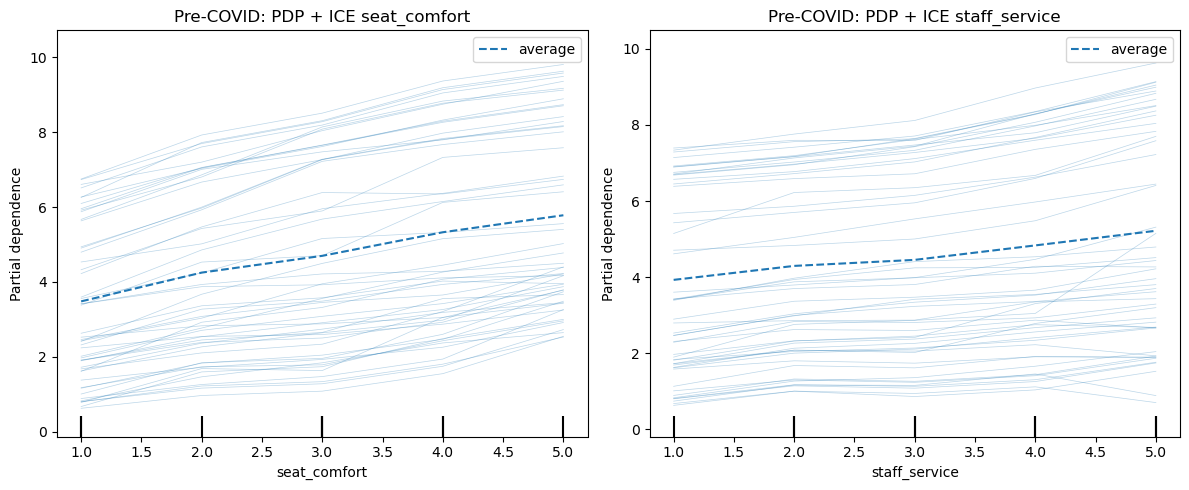

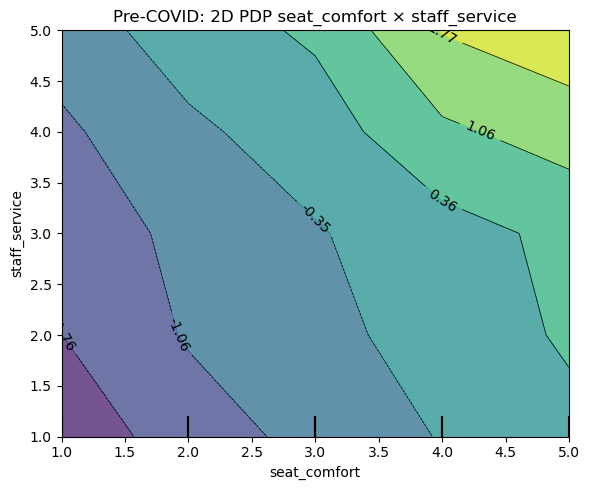

In [96]:
# Pre-COVID strongest interaction
X_pre = df_pre_data[pre_feats].fillna(0)
y_pre = df_pre_data["overall_rating"]
plot_interactions(X_pre, y_pre, ["seat_comfort", "staff_service"], GradientBoostingRegressor(), "Pre-COVID")

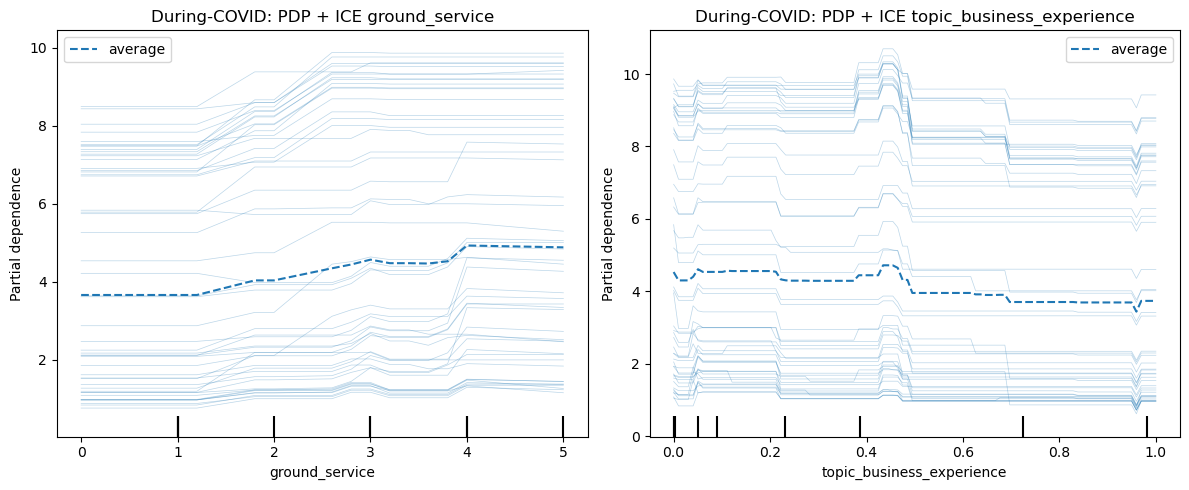

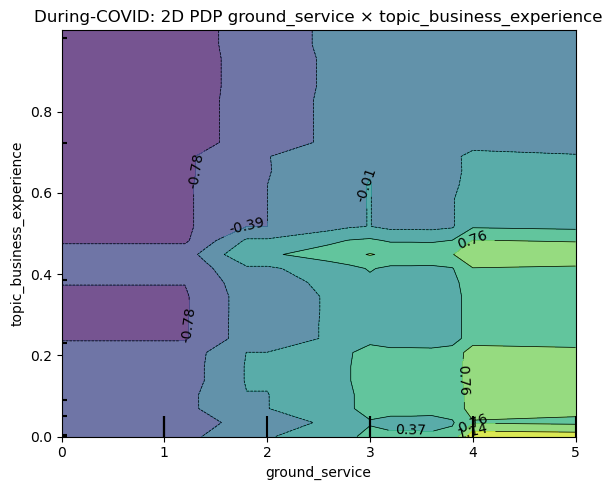

In [97]:
# During-COVID strongest interaction
X_during = df_during_data[during_feats].fillna(0)
y_during = df_during_data["overall_rating"]
plot_interactions(X_during, y_during, ["ground_service", "topic_business_experience"], GradientBoostingRegressor(), "During-COVID")

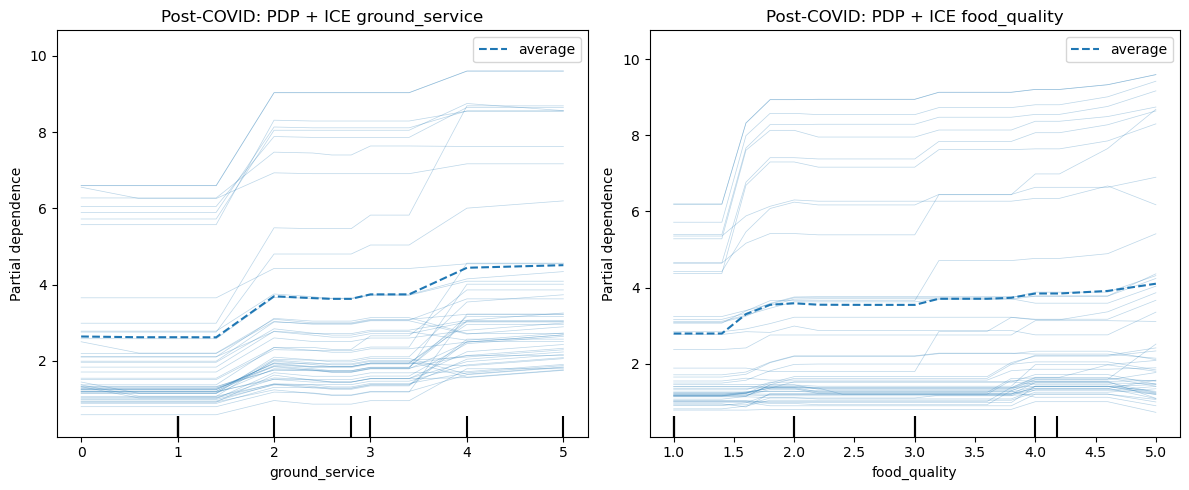

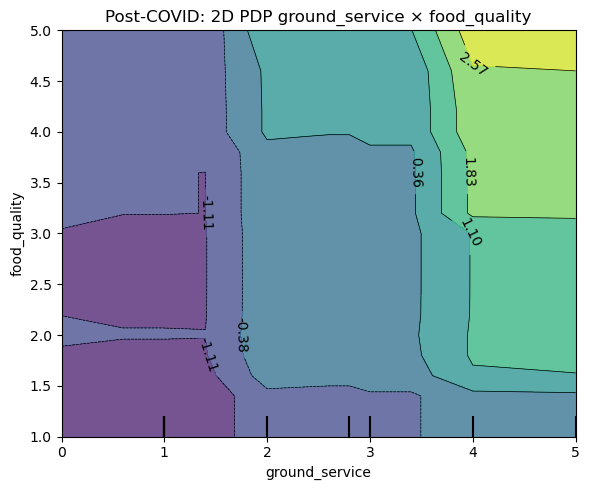

In [98]:
# Post-COVID strongest interaction
X_post = df_post_data[post_feats].fillna(0)
y_post = df_post_data["overall_rating"]
plot_interactions(X_post, y_post, ["ground_service", "food_quality"], GradientBoostingRegressor(), "Post-COVID")

In [41]:
# ===================================
# AUTOMATED PDP + ICE + 2D PDP PLOTS
# ===================================
from sklearn.inspection import PartialDependenceDisplay

def plot_pdp_ice_and_interactions(X, y, model, top_interactions, period_name, outdir="pdp_plots"):
    import os
    os.makedirs(outdir, exist_ok=True)

    # Limit to top 5 interactions
    top5 = top_interactions.head(5)

    for i, (f1, f2, _) in enumerate(top5.itertuples(index=False)):
        # --- PDP + ICE for Feature 1 ---
        fig, ax = plt.subplots(figsize=(6, 4))
        PartialDependenceDisplay.from_estimator(model, X, [f1], kind="both", ax=ax)
        plt.title(f"PDP + ICE for {f1} ({period_name})")
        plt.tight_layout()
        plt.savefig(f"{outdir}/{period_name}_PDP_ICE_{f1}.png")
        plt.close()

        # --- PDP + ICE for Feature 2 ---
        fig, ax = plt.subplots(figsize=(6, 4))
        PartialDependenceDisplay.from_estimator(model, X, [f2], kind="both", ax=ax)
        plt.title(f"PDP + ICE for {f2} ({period_name})")
        plt.tight_layout()
        plt.savefig(f"{outdir}/{period_name}_PDP_ICE_{f2}.png")
        plt.close()

        # --- 2D PDP for the pair ---
        fig, ax = plt.subplots(figsize=(6, 5))
        PartialDependenceDisplay.from_estimator(model, X, [(f1, f2)], ax=ax, kind="average")
        plt.title(f"2D PDP: {f1} × {f2} ({period_name})")
        plt.tight_layout()
        plt.savefig(f"{outdir}/{period_name}_2D_PDP_{f1}_{f2}.png")
        plt.close()

        print(f"Saved PDP/ICE and 2D PDP for {f1} × {f2} ({period_name})")


# ===================================
# RUN FOR PRE, DURING, POST
# ===================================

# Train models once per period
from sklearn.model_selection import train_test_split

def train_lgb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=0.2, random_state=42)
    model = lgb.LGBMRegressor(n_estimators=500, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    return model, X_test, y_test

# Pre-COVID
model_pre, X_pre_test, y_pre_test = train_lgb(df_pre_data[pre_feats], df_pre_data["overall_rating"])
plot_pdp_ice_and_interactions(X_pre_test, y_pre_test, model_pre, top_pre, "Pre-COVID")

# During-COVID
model_during, X_during_test, y_during_test = train_lgb(df_during_data[during_feats], df_during_data["overall_rating"])
plot_pdp_ice_and_interactions(X_during_test, y_during_test, model_during, top_during, "During-COVID")

# Post-COVID
model_post, X_post_test, y_post_test = train_lgb(df_post_data[post_feats], df_post_data["overall_rating"])
plot_pdp_ice_and_interactions(X_post_test, y_post_test, model_post, top_post, "Post-COVID")


Saved PDP/ICE and 2D PDP for food_quality × staff_sentiment (Pre-COVID)
Saved PDP/ICE and 2D PDP for seat_comfort × staff_service (Pre-COVID)
Saved PDP/ICE and 2D PDP for seat_comfort × food_quality (Pre-COVID)
Saved PDP/ICE and 2D PDP for seat_comfort × food_sentiment (Pre-COVID)
Saved PDP/ICE and 2D PDP for food_quality × food_sentiment (Pre-COVID)
Saved PDP/ICE and 2D PDP for food_quality × staff_sentiment (During-COVID)
Saved PDP/ICE and 2D PDP for ground_service × topic_business_experience (During-COVID)
Saved PDP/ICE and 2D PDP for ground_service × staff_sentiment (During-COVID)
Saved PDP/ICE and 2D PDP for seat_comfort × food_sentiment (During-COVID)
Saved PDP/ICE and 2D PDP for staff_sentiment × topic_business_experience (During-COVID)
Saved PDP/ICE and 2D PDP for ground_service × food_sentiment (Post-COVID)
Saved PDP/ICE and 2D PDP for seat_comfort × ground_service (Post-COVID)
Saved PDP/ICE and 2D PDP for ground_service × topic_refunds_lounge (Post-COVID)
Saved PDP/ICE and 2D

## Statstical Testing for Feature Interaction
### Validation of Top Interactions (OLS + Permutation + Bootstrap)

Purpose: statistically verify that specific feature interactions add real signal beyond main effects.

Steps:
- Fit an OLS with main effects (f1, f2) and their product (f1×f2); inspect the interaction coefficient and R².
- Run a permutation test on y to check that the observed R² is far from chance.
- Bootstrap the interaction coefficient to obtain a 95% confidence interval for its magnitude and sign.

Interpretation guide:
- Significant positive coef → synergy (combined effect > sum of parts).
- Significant negative coef → conflict (combined effect < sum of parts).
- High true R² vs. permuted and a CI not crossing 0 → robust interaction.

In [43]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap

def stability_test(X, y, top_pairs, n_runs=5, sample_size=3000):
    stability = {pair: 0 for pair in top_pairs}

    for seed in range(n_runs):
        np.random.seed(seed)
        sample_idx = np.random.choice(X.index, size=min(sample_size, len(X)), replace=False)
        X_sample = X.loc[sample_idx].fillna(0)
        y_sample = y.loc[sample_idx]

        model = lgb.LGBMRegressor(n_estimators=500, max_depth=6, random_state=seed, verbose=-1)
        model.fit(X_sample, y_sample)

        explainer = shap.TreeExplainer(model)
        shap_inter = explainer.shap_interaction_values(X_sample)

        # Rank interactions
        feat_names = X_sample.columns
        pairs = []
        for i in range(len(feat_names)):
            for j in range(i+1, len(feat_names)):
                score = np.mean(np.abs(shap_inter[:, i, j]))
                pairs.append((feat_names[i], feat_names[j], score))
        df_pairs = pd.DataFrame(pairs, columns=["Feature1","Feature2","MeanAbsSHAP"]).sort_values("MeanAbsSHAP", ascending=False)

        # Check if our target pairs appear in top 10
        top10 = set([tuple(sorted((a,b))) for a,b in df_pairs.head(10)[["Feature1","Feature2"]].values])
        for p in top_pairs:
            if tuple(sorted(p)) in top10:
                stability[p] += 1

    return stability

In [45]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def regression_test(X, y, f1, f2):
    X_int = X.copy()
    X_int[f"{f1}_{f2}"] = X_int[f1] * X_int[f2]

    X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size=0.2, random_state=42)

    # Add constant for OLS
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    pred = model.predict(sm.add_constant(X_test))

    return model.summary(), r2_score(y_test, pred)

# Pre Covid


=== Pre-COVID Validation ===

OLS Results for seat_comfort × staff_service
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     1778.
Date:                Mon, 01 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:43:26   Log-Likelihood:                -5086.8
No. Observations:                2559   AIC:                         1.018e+04
Df Residuals:                    2555   BIC:                         1.020e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

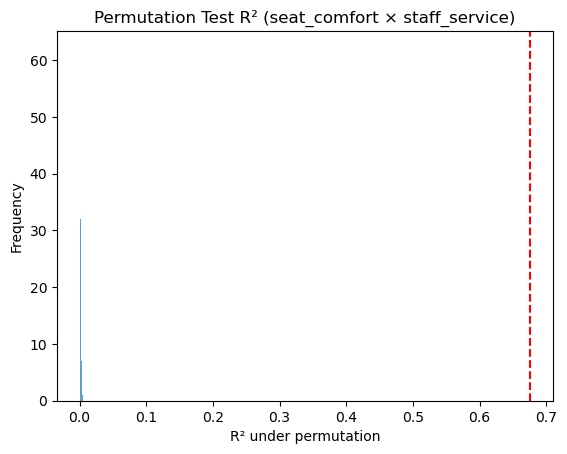

True R²: 0.676
Mean permuted R²: 0.001
Percentile rank of True R²: 100.0%


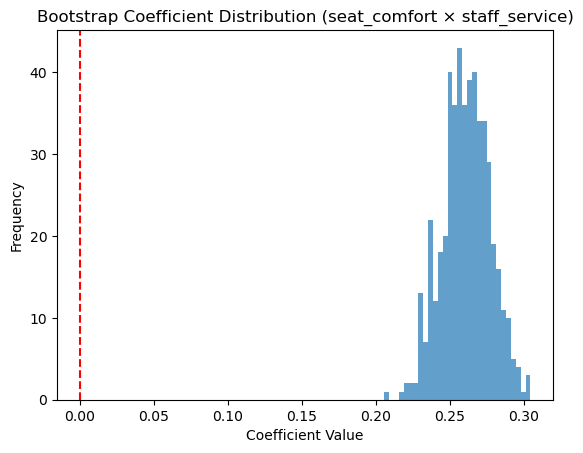

Bootstrap mean coef: 0.261
95% CI: [0.230, 0.291]


In [102]:
# =========================================================
# VALIDATION OF TOP INTERACTIONS (Pre & During COVID)
# =========================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# =============== 1. OLS REGRESSION ===============
def test_interaction_ols(df, f1, f2, y_col="overall_rating"):
    X = df[[f1, f2]].copy()
    X[f"{f1}_{f2}"] = X[f1] * X[f2]
    X = sm.add_constant(X)
    y = df[y_col]

    model = sm.OLS(y, X).fit()
    print(f"\nOLS Results for {f1} × {f2}")
    print(model.summary())

    return model.rsquared, model.params[f"{f1}_{f2}"]

# =============== 2. Permutation Test ===============
def permutation_test(df, f1, f2, y_col="overall_rating", n_perms=500):
    # True R²
    X = df[[f1, f2]].copy()
    X[f"{f1}_{f2}"] = X[f1] * X[f2]
    X = sm.add_constant(X)
    y = df[y_col]
    model = sm.OLS(y, X).fit()
    true_r2 = model.rsquared

    perm_r2s = []
    for _ in range(n_perms):
        y_perm = np.random.permutation(y)
        model_perm = sm.OLS(y_perm, X).fit()
        perm_r2s.append(model_perm.rsquared)

    plt.hist(perm_r2s, bins=30, alpha=0.7)
    plt.axvline(true_r2, color="red", linestyle="--")
    plt.title(f"Permutation Test R² ({f1} × {f2})")
    plt.xlabel("R² under permutation")
    plt.ylabel("Frequency")
    plt.show()

    print(f"True R²: {true_r2:.3f}")
    print(f"Mean permuted R²: {np.mean(perm_r2s):.3f}")
    print(f"Percentile rank of True R²: {np.mean(true_r2 > np.array(perm_r2s)) * 100:.1f}%")

# =============== 3. Bootstrap CI ===============
def bootstrap_interaction(df, f1, f2, y_col="overall_rating", n_boot=500):
    coefs = []
    for _ in range(n_boot):
        df_boot = resample(df, replace=True, n_samples=len(df))
        X = df_boot[[f1, f2]].copy()
        X[f"{f1}_{f2}"] = X[f1] * X[f2]
        X = sm.add_constant(X)
        y = df_boot[y_col]
        model = sm.OLS(y, X).fit()
        coefs.append(model.params[f"{f1}_{f2}"])

    mean_coef = np.mean(coefs)
    ci_lower, ci_upper = np.percentile(coefs, [2.5, 97.5])

    plt.hist(coefs, bins=30, alpha=0.7)
    plt.axvline(0, color="red", linestyle="--")
    plt.title(f"Bootstrap Coefficient Distribution ({f1} × {f2})")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Frequency")
    plt.show()

    print(f"Bootstrap mean coef: {mean_coef:.3f}")
    print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# =========================================================
# RUN VALIDATIONS
# =========================================================

# --- Pre-COVID: seat_comfort × food_quality ---
print("\n=== Pre-COVID Validation ===")
r2_pre, coef_pre = test_interaction_ols(df_pre_data, "seat_comfort", "staff_service")
permutation_test(df_pre_data, "seat_comfort", "staff_service")
bootstrap_interaction(df_pre_data, "seat_comfort", "staff_service")

# During Covid


=== During-COVID Validation ===

OLS Results for ground_service × topic_business_experience
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     126.3
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           9.61e-45
Time:                        02:45:49   Log-Likelihood:                -396.70
No. Observations:                 191   AIC:                             801.4
Df Residuals:                     187   BIC:                             814.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
--------

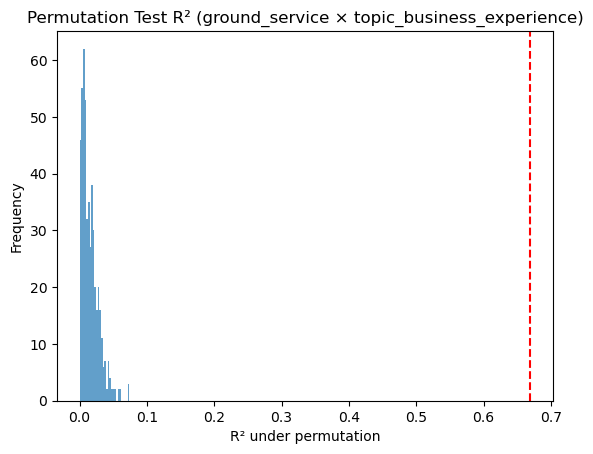

True R²: 0.670
Mean permuted R²: 0.016
Percentile rank of True R²: 100.0%


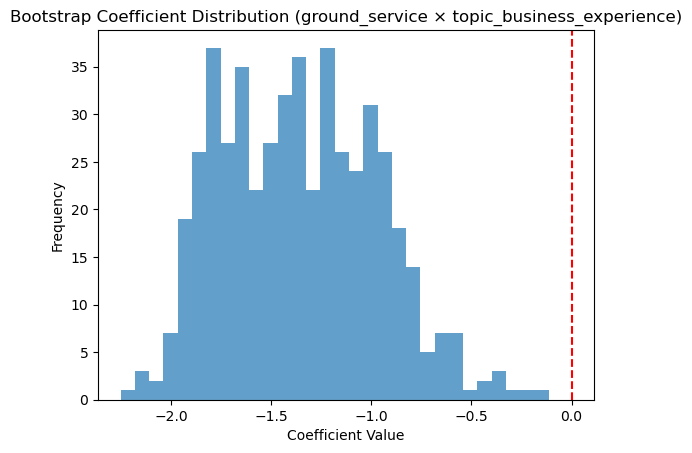

Bootstrap mean coef: -1.357
95% CI: [-1.964, -0.580]


In [103]:
# --- During-COVID: ground_service × staff_sentiment ---
print("\n=== During-COVID Validation ===")
r2_during, coef_during = test_interaction_ols(df_during_data, "ground_service", "topic_business_experience")
permutation_test(df_during_data, "ground_service", "topic_business_experience")
bootstrap_interaction(df_during_data,"ground_service", "topic_business_experience")

# Post Covid


=== Post-COVID Validation ===

OLS Results for ground_service × food_quality
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     351.3
Date:                Mon, 01 Sep 2025   Prob (F-statistic):          7.17e-119
Time:                        02:52:46   Log-Likelihood:                -913.06
No. Observations:                 467   AIC:                             1834.
Df Residuals:                     463   BIC:                             1851.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

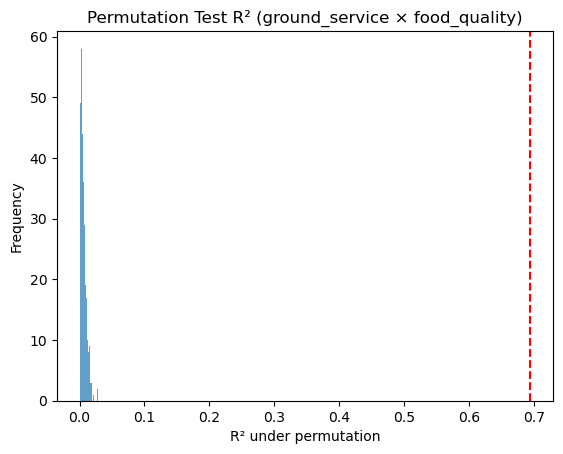

True R²: 0.695
Mean permuted R²: 0.006
Percentile rank of True R²: 100.0%


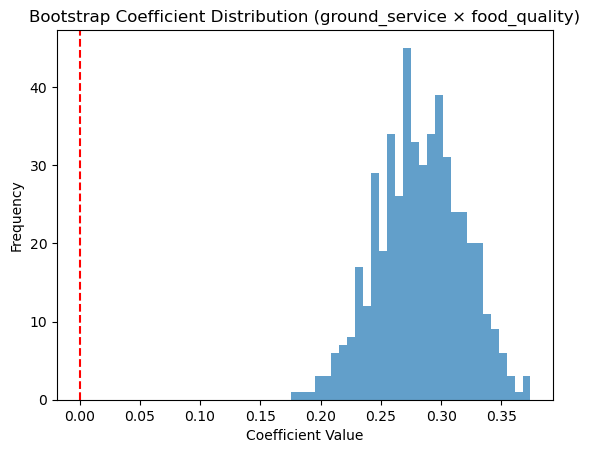

Bootstrap mean coef: 0.283
95% CI: [0.213, 0.349]


In [106]:
print("\n=== Post-COVID Validation ==="); r2_post, coef_post = test_interaction_ols(df_post_data, "ground_service", "food_quality")
permutation_test(df_post_data, "ground_service", "food_quality")
bootstrap_interaction(df_post_data, "ground_service", "food_quality")

# MCR Shortlist compared to Full Feature SHAP Interaction 
### Feature Interaction Analysis: Full vs. MCR Shortlist

Test feature interactions under two setups:

1. **Full Feature Set** – all features (excluding target, metadata, and collinear/leaky ones).  
2. **MCR Shortlist** – only **Core + Volatile features** from MCR screening.  

For each setup, the **top-N feature interactions** are identified using SHAP interaction values derived from a LightGBM model,
enabling a comparison of whether MCR-based filtering emphasizes more meaningful brand-related dynamics.

Shapes: (3217, 46) (29, 3) (29, 3) (29, 3)
Pre-COVID: (2559, 47)
During-COVID: (191, 47)
Post-COVID: (467, 47)
Pre-COVID usable features: 15
During-COVID usable features: 15
Post-COVID usable features: 15

>>> Running FULL feature interactions for Pre-COVID

=== Top 10 Interactions (Pre-COVID (All Features)) ===


,Feature1,Feature2,MeanAbsSHAP
176,food_quality,staff_sentiment,0.104714
71,seat_comfort,staff_service,0.097879
73,seat_comfort,food_quality,0.090258
78,seat_comfort,food_sentiment,0.079956
174,food_quality,food_sentiment,0.072761
111,staff_service,food_sentiment,0.065887
72,seat_comfort,ground_service,0.050446
80,seat_comfort,staff_sentiment,0.049481
113,staff_service,staff_sentiment,0.047056
106,staff_service,food_quality,0.037190


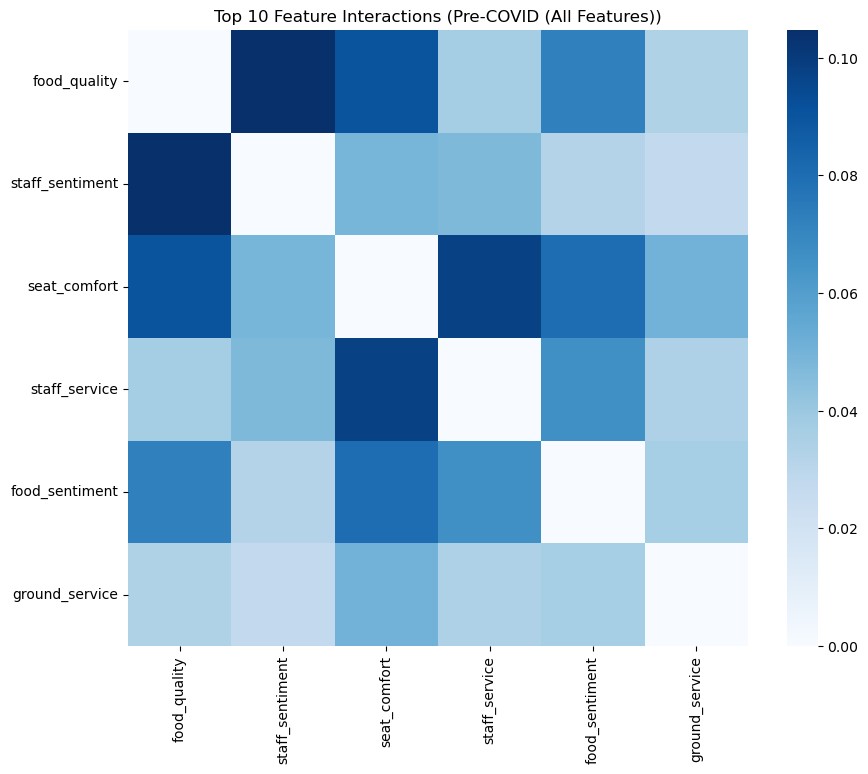


>>> Running MCR-SHORTLIST feature interactions for Pre-COVID

=== Top 10 Interactions (Pre-COVID (MCR Shortlist)) ===


,Feature1,Feature2,MeanAbsSHAP
42,food_quality,staff_sentiment,0.103044
0,seat_comfort,staff_service,0.102450
2,seat_comfort,food_quality,0.089049
4,seat_comfort,food_sentiment,0.088691
40,food_quality,food_sentiment,0.076448
17,staff_service,food_sentiment,0.065339
6,seat_comfort,staff_sentiment,0.054244
1,seat_comfort,ground_service,0.047849
19,staff_service,staff_sentiment,0.047005
61,food_sentiment,staff_sentiment,0.042292


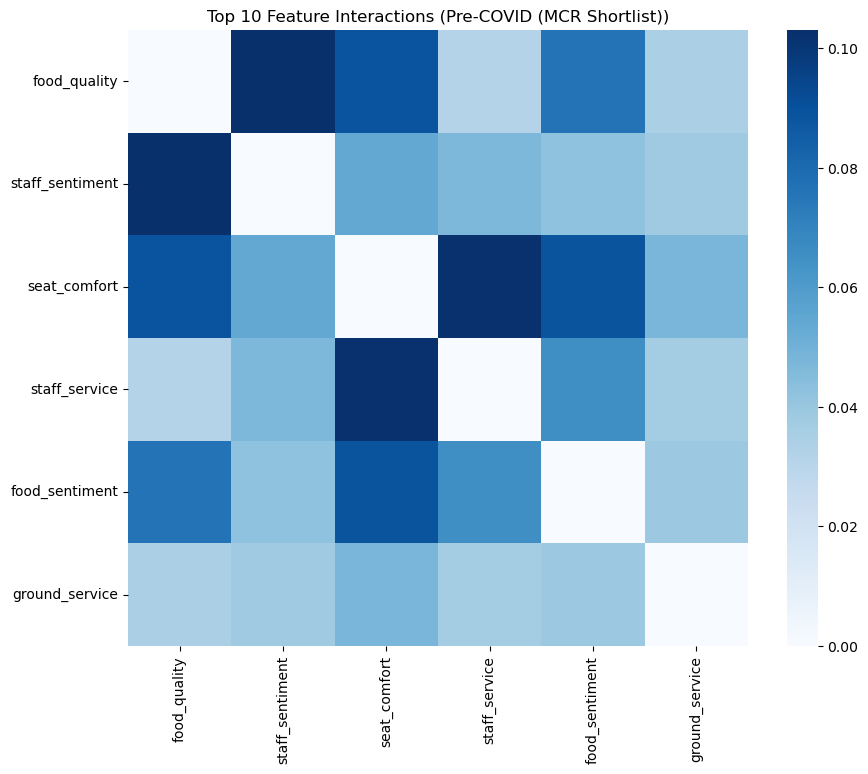

In [107]:
def run_period_analysis(df_period, mcr_feats, period_name, top_n=10):
    y = df_period["overall_rating"]

    # (A) All features (drop target + metadata + redundant/leaky vars)
    drop_cols = [
        "overall_rating",     # target
        "review_date",        # timestamp
        "sentiment_score",    # redundant with aspect sentiments
        "optimism", "joy", "anger", "sadness",  # emotional overlaps
        "recommended",        # outcome label
        "covid_period",       # derived label
        "value_for_money"     # often collinear with rating
    ]
    X_all = df_period.drop(columns=[c for c in drop_cols if c in df_period.columns])

    print(f"\n>>> Running FULL feature interactions for {period_name}")
    inter_all = get_interactions(X_all, y, f"{period_name} (All Features)", top_n)

    # (B) MCR-shortlisted features
    X_mcr = df_period[mcr_feats]
    print(f"\n>>> Running MCR-SHORTLIST feature interactions for {period_name}")
    inter_mcr = get_interactions(X_mcr, y, f"{period_name} (MCR Shortlist)", top_n)

    return inter_all, inter_mcr

# 6.  RUN: PRE-COVID

inter_all_pre, inter_mcr_pre = run_period_analysis(
    df_pre_data,
    pre_feats,
    "Pre-COVID",
    top_n=10
)


>>> Running FULL feature interactions for During-COVID

=== Top 10 Interactions (During-COVID (All Features)) ===


,Feature1,Feature2,MeanAbsSHAP
176,food_quality,staff_sentiment,0.115366
155,ground_service,topic_business_experience,0.100143
78,seat_comfort,food_sentiment,0.072233
145,ground_service,staff_sentiment,0.067271
178,food_quality,refunds_sentiment,0.053022
72,seat_comfort,ground_service,0.052211
375,staff_sentiment,topic_business_experience,0.050072
367,staff_sentiment,refunds_sentiment,0.043413
326,food_sentiment,topic_business_experience,0.038666
318,food_sentiment,refunds_sentiment,0.034233


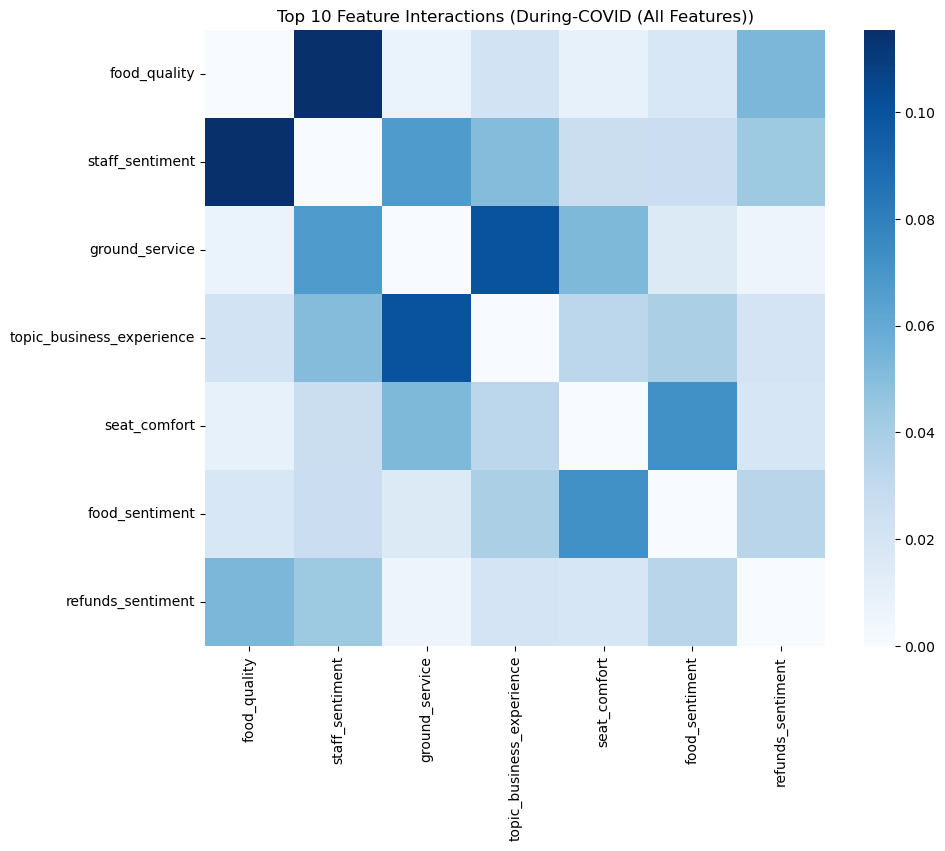


>>> Running MCR-SHORTLIST feature interactions for During-COVID

=== Top 10 Interactions (During-COVID (MCR Shortlist)) ===


,Feature1,Feature2,MeanAbsSHAP
42,food_quality,staff_sentiment,0.120879
38,ground_service,topic_business_experience,0.114934
31,ground_service,staff_sentiment,0.077118
4,seat_comfort,food_sentiment,0.072371
83,staff_sentiment,topic_business_experience,0.069454
37,ground_service,topic_refunds_lounge,0.049501
43,food_quality,refunds_sentiment,0.047688
1,seat_comfort,ground_service,0.043168
70,seat_sentiment,refunds_sentiment,0.041723
19,staff_service,staff_sentiment,0.041584


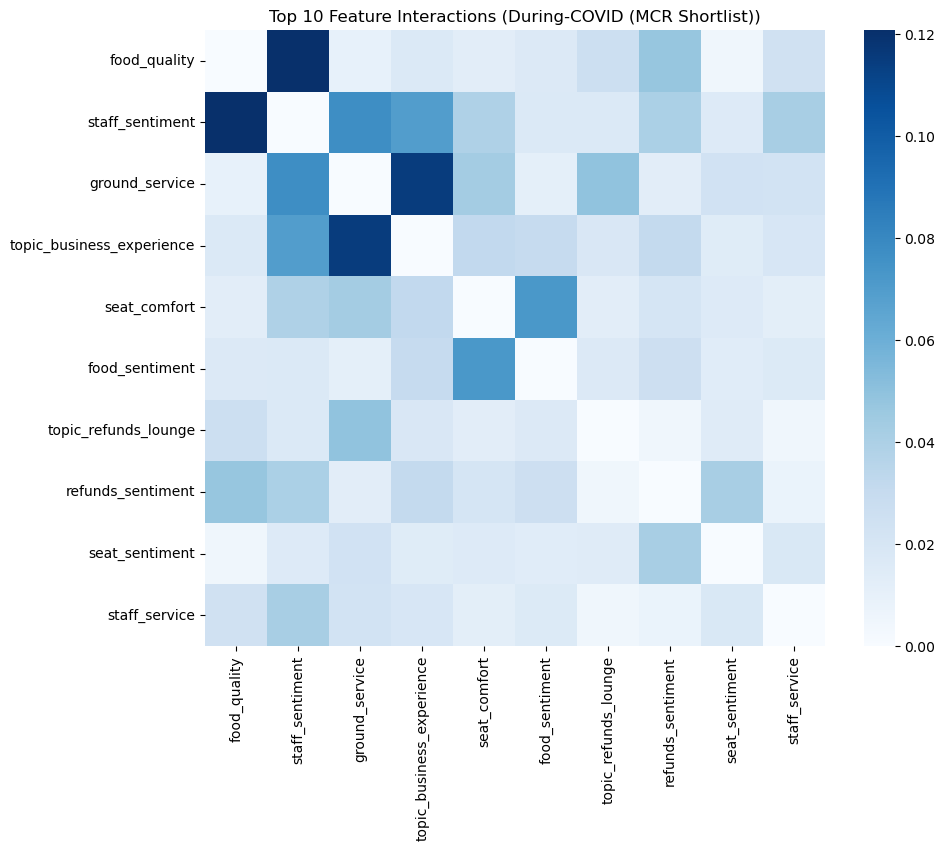

In [108]:
# DURING-COVID ANALYSIS
inter_all_during, inter_mcr_during = run_period_analysis(
    df_during_data,
    during_feats,
    "During-COVID",
    top_n=10
)


>>> Running FULL feature interactions for post-COVID

=== Top 10 Interactions (post-COVID (All Features)) ===


,Feature1,Feature2,MeanAbsSHAP
143,ground_service,food_sentiment,0.117484
72,seat_comfort,ground_service,0.102031
154,ground_service,topic_refunds_lounge,0.059547
138,ground_service,food_quality,0.049190
80,seat_comfort,staff_sentiment,0.046651
78,seat_comfort,food_sentiment,0.041667
368,staff_sentiment,lounge_sentiment,0.039269
185,food_quality,topic_refunds_lounge,0.037332
180,food_quality,entertainment_sentiment,0.036943
111,staff_service,food_sentiment,0.032952


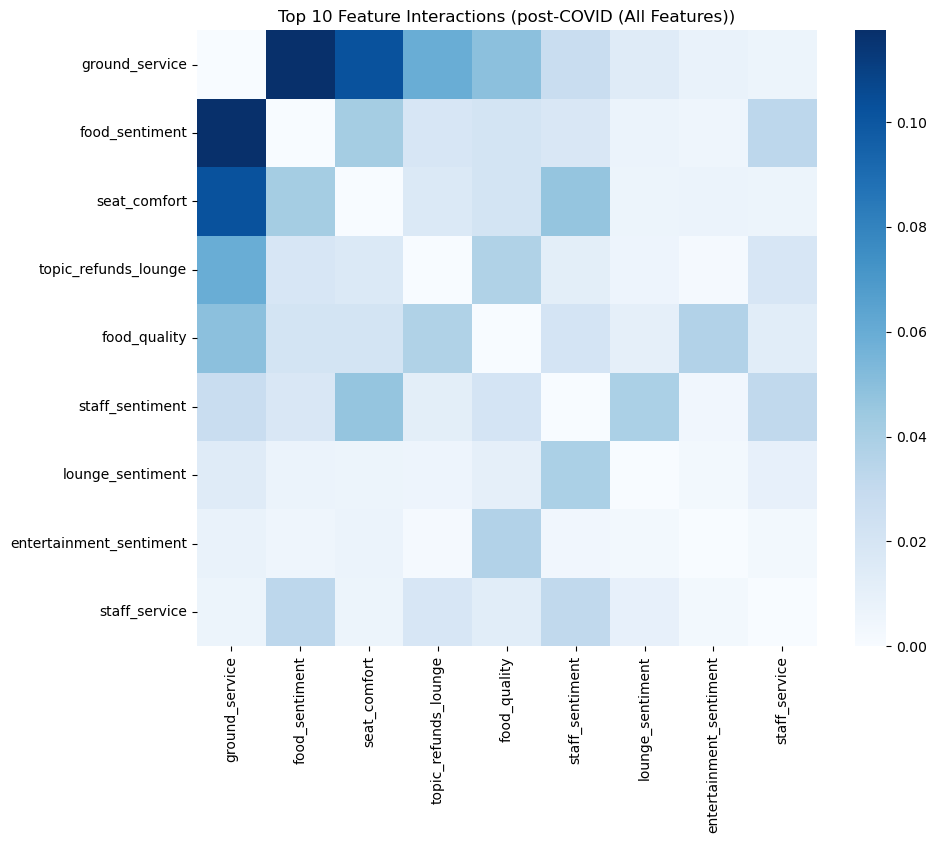


>>> Running MCR-SHORTLIST feature interactions for post-COVID

=== Top 10 Interactions (post-COVID (MCR Shortlist)) ===


,Feature1,Feature2,MeanAbsSHAP
28,ground_service,food_sentiment,0.122288
1,seat_comfort,ground_service,0.096917
36,ground_service,topic_refunds_lounge,0.073047
5,seat_comfort,staff_sentiment,0.056527
27,ground_service,food_quality,0.055680
71,staff_sentiment,lounge_sentiment,0.054335
47,food_quality,topic_refunds_lounge,0.044032
41,food_quality,staff_sentiment,0.042335
3,seat_comfort,food_sentiment,0.040130
50,food_sentiment,seat_sentiment,0.036543


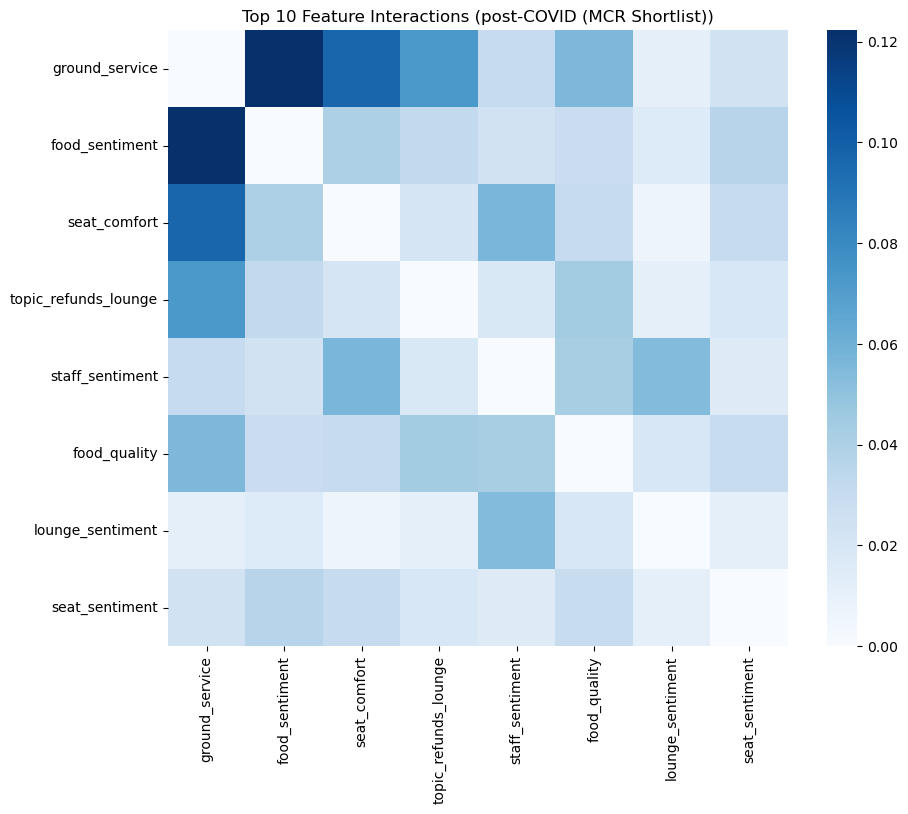

In [111]:
# Post-COVID ANALYSIS
inter_all_post, inter_mcr_post = run_period_analysis(
    df_post_data,
    post_feats,
    "post-COVID",
    top_n=10
)